<a href="https://colab.research.google.com/github/KisirinyaSirajje/LLaVA-Evaluation/blob/main/LLaVA_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install transformers accelerate torch torchvision Pillow
!pip install git+https://github.com/huggingface/transformers.git

# Import necessary libraries
from transformers import LlavaProcessor, LlavaForConditionalGeneration
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-ed2_f5e6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ed2_f5e6
  Resolved https://github.com/huggingface/transformers.git to commit b62e5b605129100ea740d46f7ff8d4d00e936e1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.57.0.dev0-py3-none-any.whl size=12594258 sha256=57575c5c424fcba0a7124be8b6994a7157ebf4b2c012510f0812c263a7f4827f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mxfdnyd4/wheels/54/cb/3f/83103de5575c534436d6a4686686dead458238dfaf1147e98d
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.0
    Uninstalling transformers-4.56.0:
      Successfully uninstalled transformers-4.56.0
Using device: cuda
GPU: Tes

In [2]:
# Load LLaVA model and processor
model_id = "llava-hf/llava-1.5-7b-hf"
processor = LlavaProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("LLaVA model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

LLaVA model loaded successfully!


Upload a sign language image for testing:


Saving imag2.jpg to imag2.jpg


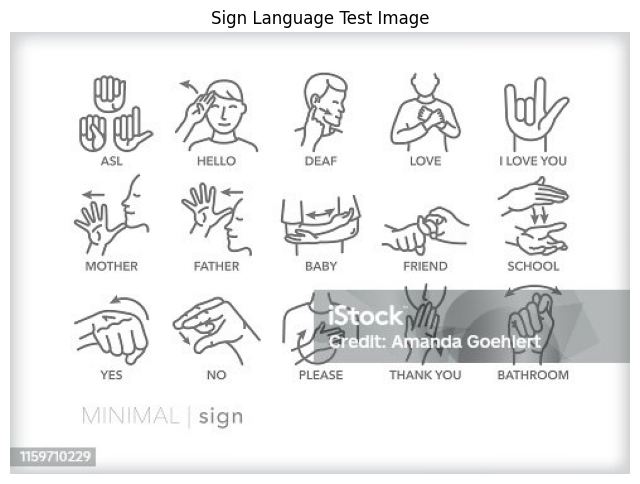

In [3]:
# Upload your sign language image
print("Upload a sign language image for testing:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).convert("RGB")

# Display the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title("Sign Language Test Image")
plt.show()

In [4]:
# Define prompts specifically for sign language analysis
sign_language_prompts = [
    "USER: <image>\nWhat specific sign language gesture is shown in this image? Describe the hand shapes and positions.\nASSISTANT:",
    "USER: <image>\nAnalyze the hand configuration for sign language. What letters or words might this represent?\nASSISTANT:",
    "USER: <image>\nIs this American Sign Language (ASL) or another sign language? Describe the gesture in detail.\nASSISTANT:",
    "USER: <image>\nWhat are the exact finger positions and hand orientation in this sign?\nASSISTANT:",
    "USER: <image>\nCould this sign be part of a sentence? What might it be communicating?\nASSISTANT:"
]

print("Running LLaVA evaluation on sign language image...")
print("=" * 60)

results = {}
for i, prompt in enumerate(sign_language_prompts):
    print(f"\nPrompt {i+1}: {prompt.split('ASSISTANT:')[0].strip()}")

    # Process the input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch.float16)

    # Generate response
    output = model.generate(**inputs, max_new_tokens=150, do_sample=True)

    # Decode and print the result
    result = processor.decode(output[0], skip_special_tokens=True)
    answer = result.split("ASSISTANT:")[-1].strip()
    results[prompt] = answer
    print(f"Answer: {answer}")

    # Add a separator
    if i < len(sign_language_prompts) - 1:
        print("-" * 40)

print("\n" + "=" * 60)
print("EVALUATION COMPLETE!")
print("=" * 60)

Running LLaVA evaluation on sign language image...

Prompt 1: USER: <image>
What specific sign language gesture is shown in this image? Describe the hand shapes and positions.
Answer: The specific sign language gesture shown in this image is a hand gesture called "Hello." The person is giving a thumbs-up sign by bringing the thumb upward while keeping the other fingers curled in at the base of the thumb. This sign is often used in various contexts to indicate good or enthusiastic feedback, greetings, or endorsements.
----------------------------------------

Prompt 2: USER: <image>
Analyze the hand configuration for sign language. What letters or words might this represent?
Answer: Analyzing the hand signals in the image, we can make out various letters and phrases. There are hands labeled with the word "hello," a peace sign, a heart, and some thumb signs. The heart seems to be the most dominant symbol in the collection. While there are multiple symbols, they do not appear to form a co

In [5]:
# Save results to a file
with open('llava_results.txt', 'w') as f:
    for prompt, answer in results.items():
        f.write(f"PROMPT: {prompt}\n")
        f.write(f"ANSWER: {answer}\n")
        f.write("-" * 80 + "\n")

print("Results saved to 'llava_results.txt'")

# Take screenshots (you'll need to do this manually)
print("\nPlease take screenshots of:")
print("1. The code cells showing successful execution")
print("2. The output showing LLaVA's responses")
print("3. The test image used for evaluation")

Results saved to 'llava_results.txt'

Please take screenshots of:
1. The code cells showing successful execution
2. The output showing LLaVA's responses
3. The test image used for evaluation


In [6]:
# Create a new directory for LLaVA evaluation
!mkdir LLaVA-Evaluation
%cd LLaVA-Evaluation

# Initialize git
!git init
!git config --global init.defaultBranch main
!git config --global user.name "KisirinyaSirajje"
!git config --global user.email "kisirinyasiraje@gmail.com"  # Replace with your actual email

/content/LLaVA-Evaluation
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/LLaVA-Evaluation/.git/
